##### Importy

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.src.layers import BatchNormalization, Dropout
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import warnings
import keras_tuner as kt
import itertools
import time
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
# df_final = pd.read_csv("all_data.csv", parse_dates=['timestamp'])
warnings.filterwarnings('ignore')

##### 1. Wczytanie danych

In [5]:
# df_final = pd.read_csv("all_data.csv", parse_dates=['timestamp'])

In [6]:
def visualize(building_data, type=None):
    if type == "small":
        building_data = building_data[(building_data['timestamp'].dt.year == 2017)&(building_data['timestamp'].dt.month == 3)].sort_values('timestamp')

    plt.figure(figsize=(15, 6))
    plt.plot(building_data['timestamp'], building_data['energy_consumption'], alpha=0.7)
    plt.title(f'Zużycie energii w czasie dla budynku {building_data["building_id"]} (2017)\n'
              f'Średnia temperatura: {building_data["airTemperature"].mean():.1f}°C', fontsize=14)
    plt.xlabel('Czas', fontsize=12)
    plt.ylabel('Zużycie energii', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [7]:
def load_and_preprocess(file_path = None, data = None):
    if data is None:
        data = pd.read_csv(file_path, parse_dates=['timestamp'])
    data = data.sort_values('timestamp').set_index('timestamp')
    data = data.asfreq('H')

    for col in data.columns:
        data[col] = data[col].replace([np.inf, -np.inf], np.nan)
        data[col] = data[col].interpolate(method='time', limit_direction='both')
        data[col] = data[col].ffill().bfill()

    return data[['energy_consumption', 'airTemperature']]

##### Parametry ARIMA/ARIMAX

In [41]:
def find_arima_params(train):

    d = determine_differencing_order(train)
    stationary_series = train.diff(d).dropna() if d > 0 else train.copy()

    max_lags = 20
    acf_vals = acf(stationary_series, nlags=max_lags, fft=True)
    pacf_vals = pacf(stationary_series, nlags=max_lags)

    p_range = suggest_p_from_pacf(pacf_vals)
    q_range = suggest_q_from_acf(acf_vals)

    best_aic = np.inf
    best_order = (1, d, 1)

    # Generuj wszystkie kombinacje p i q
    pdq = itertools.product(p_range, [d], q_range)

    for order in pdq:
        try:
            model = ARIMA(train, order=order).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
        except:
            continue

    validated_order = validate_arima_order(train, best_order)

    warnings.resetwarnings()
    return validated_order


def determine_differencing_order(series, max_diff=2):
    """
    Określa rząd różnicowania (d) na podstawie testów stacjonarności
    """
    for d in range(max_diff + 1):
        if d > 0:
            diff_series = series.diff(d).dropna()
        else:
            diff_series = series.copy()

        # Test ADF
        adf_result = adfuller(diff_series)
        # Test KPSS
        try:
            kpss_result = kpss(diff_series, regression='c')
        except:
            kpss_result = (None, 1.0)

        if adf_result[1] <= 0.05 and kpss_result[1] > 0.05:
            return d

    return max_diff  # Zwróć maksymalny testowany rząd


def suggest_p_from_pacf(pacf_vals, threshold=0.2):
    """
    Sugeruje zakres p na podstawie PACF
    """
    significant_lags = np.where(np.abs(pacf_vals) > threshold)[0]
    if len(significant_lags) > 0:
        max_p = min(np.max(significant_lags) + 2, 5)  # Ogranicz do 5
        return range(0, max_p + 1)
    return [0, 1, 2]


def suggest_q_from_acf(acf_vals, threshold=0.2):
    """
    Sugeruje zakres q na podstawie ACF
    """
    significant_lags = np.where(np.abs(acf_vals) > threshold)[0]
    if len(significant_lags) > 0:
        max_q = min(np.max(significant_lags) + 2, 5)  # Ogranicz do 5
        return range(0, max_q + 1)
    return [0, 1, 2]


def validate_arima_order(series, order, n_folds=3):
    """
    Walidacja parametrów z użyciem kroczącej walidacji
    """
    p, d, q = order
    train_size = len(series)
    fold_size = train_size // (n_folds + 1)

    aic_scores = []

    for i in range(1, n_folds + 1):
        train = series.iloc[:i * fold_size]
        try:
            model = ARIMA(train, order=order).fit()
            aic_scores.append(model.aic)
        except:
            aic_scores.append(np.inf)

    # Sprawdź czy prostsze modele nie dają podobnych wyników
    simpler_models = [
        (max(p - 1, 0), d, q),
        (p, d, max(q - 1, 0)),
        (max(p - 1, 0), d, max(q - 1, 0))
    ]

    for test_order in simpler_models:
        try:
            model = ARIMA(series, order=test_order).fit()
            if model.aic < np.mean(aic_scores):
                return test_order
        except:
            continue

    return order

##### Parametry SARIMA/SARIMAX

In [66]:
def find_optimal_seasonal_params(train, s=24, non_seasonal_order=(1, 1, 1)):

    D = determine_seasonal_differencing_order(train, s)
    P_range = [0, 1, 2]
    Q_range = [0, 1, 2]

    best_aic = np.inf
    best_order = (1, D, 1, s)

    for P, Q in itertools.product(P_range, Q_range):
        seasonal_order = (P, D, Q, s)
        try:
            model = SARIMAX(train,
                            order=non_seasonal_order,
                            seasonal_order=seasonal_order).fit(disp=False)

            if model.aic < best_aic:
                best_aic = model.aic
                best_order = seasonal_order
        except:
            continue

    warnings.resetwarnings()
    return best_order


def determine_seasonal_differencing_order(series, s, max_D=1):
    """
    Określa sezonowy rząd różnicowania (D) na podstawie:
    - Testu Canova-Hansona dla sezonowości
    - Wizualnej inspecji sezonowych ACF
    """
    # Test Canova-Hansona (dostępny w statsmodels 0.14+)
    try:
        from statsmodels.tsa.statespace.tools import seasonal_decompose
        decomposition = seasonal_decompose(series, period=s)
        resid = decomposition.resid.dropna()
        if abs(resid).mean() < 0.1 * abs(series).mean():
            return 0
    except:
        pass

    # Różnicowanie sezonowe i test ACF
    for D in range(max_D + 1):
        if D > 0:
            diff_series = series.diff(s).dropna()
        else:
            diff_series = series.copy()

        # Sprawdź czy sezonowość została usunięta
        acf_vals = acf(diff_series, nlags=s + 3, fft=True)
        if all(abs(acf_vals[s - 1:s + 2]) < 0.2):  # Sprawdź opóźnienie sezonowe
            return D

    return max_D


##### Modele ARIMA

In [211]:
def doArimaModels(trainDataARIMA, exogData = None):

    arimaTimes = dict()

    print(trainDataARIMA)

    start = time.time()
    arima_order = find_arima_params(trainDataARIMA)
    end = time.time()
    arimaTimes["arimaSearch"] = end - start

    start = time.time()
    am = ARIMA(trainDataARIMA, order=arima_order).fit()
    end = time.time()
    arimaTimes["ARIMA"] = end - start

    start = time.time()
    seasonal_order = find_optimal_seasonal_params(trainDataARIMA, s=24, non_seasonal_order=arima_order)
    end = time.time()
    arimaTimes["arimaSeasonalSearch"] = end - start

    start = time.time()
    sm = SARIMAX(trainDataARIMA, order=arima_order, seasonal_order=seasonal_order).fit()
    end = time.time()
    arimaTimes["SARIMA"] = end - start

    if isinstance(exogData, pd.DataFrame):
        start = time.time()
        axm = ARIMA(trainDataARIMA, exog=exogData, order=arima_order).fit()
        end = time.time()
        arimaTimes["ARIMAX"] = end - start

        start = time.time()
        sxm = SARIMAX(trainDataARIMA, exog=exogData, order=arima_order,
                                seasonal_order=seasonal_order).fit()
        end = time.time()
        arimaTimes["SARIMAX"] = end - start
    else:
        axm = None
        sxm = None


    return am, sm, axm, sxm, arimaTimes


##### LSTM

In [273]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Parametry
n_steps = 24  # 24 godziny historii
n_features = 3  # energy_consumption + airTemperature + sqm

# Funkcja przygotowująca dane treningowe
def prepare_train_data(data, target_col, n_steps):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(n_steps, len(scaled)):
        X.append(scaled[i-n_steps:i, :])
        y.append(scaled[i, data.columns.get_loc(target_col)])

    return np.array(X), np.array(y), scaler

# Funkcja przygotowująca dane testowe z historią z treningu
def prepare_test_data(train_data, test_data, scaler, n_steps):
    # Połącz ostatnie n_steps z treningu z testem
    combined = pd.concat([train_data.iloc[-n_steps:], test_data])
    scaled = scaler.transform(combined)

    X_test = []
    for i in range(n_steps, len(scaled)):
        X_test.append(scaled[i-n_steps:i, :])

    return np.array(X_test)

# Budowa modelu
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', 32, 256, step=32),
        input_shape=(n_steps, n_features),
        return_sequences=False
    ))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mse'
    )
    return model

# Główny proces
def train_and_predict(train_data, test_data, target_col):

    lstm_times = dict()

    # 1. Przygotowanie danych treningowych
    X_train, y_train, scaler = prepare_train_data(train_data, target_col, n_steps)

    # 2. Strojenie i trening modelu
    start = time.time()
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        directory='tuning',
        project_name='energy_forecast'
    )

    tuner.search(X_train, y_train, epochs=20, validation_split=0.2)
    best_model = tuner.get_best_models()[0]

    end = time.time()

    lstm_times["LSTMTrain"] = end - start



    start = time.time()
    # 3. Przygotowanie danych testowych z historią
    X_test = prepare_test_data(train_data, test_data, scaler, n_steps)

    # 4. Predykcja dla 168 godzin
    predictions = best_model.predict(X_test)
    end = time.time()

    lstm_times["LSTMPredict"] = end - start

    # 5. Odwrócenie skalowania
    dummy = np.zeros((len(predictions), n_features))
    dummy[:, 0] = predictions.flatten()
    preds = scaler.inverse_transform(dummy)[:, 0]

    return preds, test_data[target_col].values, lstm_times

# # Wczytanie i przygotowanie danych
# df = pd.read_csv('one_building_data.csv', parse_dates=['timestamp'], index_col='timestamp')
# df = df.sort_index()
#
# # Wybór cech i targetu
# features = ['energy_consumption', 'airTemperature', 'sqm']
# target = 'energy_consumption'
# data = df[features].dropna()
#
# # Podział na trening (30 dni) i test (7 dni)
# train = data.iloc[-720:-168]  # 30 dni treningu
# test = data.iloc[-168:]       # 7 dni testu
#
# # Uruchomienie procesu
# predictions, true_values = train_and_predict(train, test, target)
#
# # Ocena wyników
# mse = mean_squared_error(true_values, predictions)
# mae = mean_absolute_error(true_values, predictions)
#
# print(f"MSE: {mse:.2f}, MAE: {mae:.2f}")
# print(f"Liczba przewidzianych godzin: {len(predictions)}")

##### Random Forest


In [56]:
def create_rolling_features(data, window=24):
    df = pd.DataFrame(data)
    for i in range(1, window + 1):
        df[f'lag_{i}'] = df['energy_consumption'].shift(i)

    print(df)
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    return df.dropna()

def doRandomForest(trainData, testData):

    rfTimes = dict()

    print("Trenowanie Random Forest...")
    start = time.time()
    train_rf = create_rolling_features(trainData)
    X_train_rf, y_train_rf = train_rf.drop('energy_consumption', axis=1), train_rf['energy_consumption']
    end = time.time()

    rfTimes["RFTrain"] = end - start

    start = time.time()
    test_rf = create_rolling_features(pd.concat([trainData[-24:], testData]))
    X_test_rf, y_test_rf = test_rf.drop('energy_consumption', axis=1), test_rf['energy_consumption']
    end = time.time()

    rfTimes["RFTest"] = end - start

    start = time.time()
    rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
    rf_model.fit(X_train_rf, y_train_rf)
    end = time.time()

    rfTimes["RFModel"] = end - start

    return rf_model, X_test_rf, y_test_rf, rfTimes

# doRandomForest(train, test)


##### Ewaluacja

In [169]:
def evaluate_model(y_true, y_pred, model_name, trening_time=None, model_time=None):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'Czas treningu': trening_time, 'Czas predykcji': model_time}


##### AUTO ARIMA

In [173]:
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.simplefilter(action='ignore', category=FutureWarning)

def doAutoARIMA(train_y, test_y, train_X, test_X):
    # 1. ARIMA (bez sezonowości)
    print("\n" + "="*40)
    print("=== ARIMA ===")

    start = time.time()
    auto_arima_model = pm.auto_arima(
        train_y,
        seasonal=False,  # Wyłącz sezonowość
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    end = time.time()

    arima_time = end - start

    # 2. SARIMA (z sezonowością)
    print("\n" + "="*40)
    print("=== SARIMA ===")

    start = time.time()
    auto_sarima_model = pm.auto_arima(
        train_y,
        seasonal=True,
        m=24,  # Okres sezonowości (24 godziny)
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    end = time.time()

    sarima_time = end - start

    # 3. ARIMAX (ARIMA z zmiennymi egzogenicznymi)
    print("\n" + "="*40)
    print("=== ARIMAX ===")

    start = time.time()
    auto_arimax_model = pm.auto_arima(
        train_y,
        exogenous=train_X,
        seasonal=False,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    end = time.time()

    arimax_time = end - start

    # 4. SARIMAX (SARIMA z zmiennymi egzogenicznymi)
    print("\n" + "="*40)
    print("=== SARIMAX ===")

    start = time.time()
    auto_sarimax_model = pm.auto_arima(
        train_y,
        exogenous=train_X,
        seasonal=True,
        m=24,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    end = time.time()

    sarimax_time = end - start

    autoArimaTimes = {"AutoARIMA": arima_time, "AutoSARIMA": sarima_time, "AutoARIMAX": arimax_time, "AutoSARIMAX": sarimax_time}

    return auto_arima_model, auto_sarima_model, auto_arimax_model, auto_sarimax_model, autoArimaTimes

##### Porównanie ARIMA - auto oraz własne

In [212]:
def fill_nan_with_neighbors(series):
    series = series.copy()
    for i in range(len(series)):
        if pd.isna(series[i]):
            if i == 0:
                # Jeśli NaN na początku, zastąp następną wartością
                next_val = series[i+1] if i+1 < len(series) else np.nan
                series[i] = next_val
            elif i == len(series) - 1:
                # Jeśli NaN na końcu, zastąp poprzednią wartością
                series[i] = series[i-1]
            else:
                # Średnia z poprzedniej i następnej wartości
                prev_val = series[i-1]
                next_val = series[i+1]
                if pd.isna(prev_val) and pd.isna(next_val):
                    series[i] = np.nan  # brak możliwości uzupełnienia
                elif pd.isna(prev_val):
                    series[i] = next_val
                elif pd.isna(next_val):
                    series[i] = prev_val
                else:
                    series[i] = (prev_val + next_val) / 2
    return series

Forecast NaNs: 0
552    0.439
553    0.439
554    0.439
555    0.439
556    0.439
Name: predicted_mean, dtype: float64


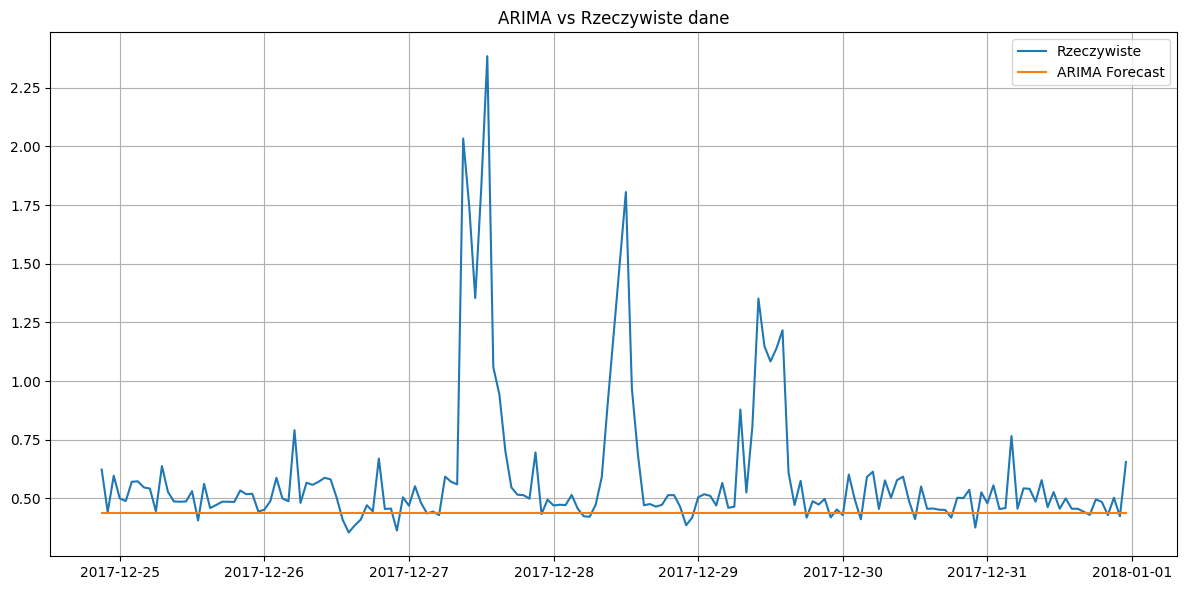

In [249]:
warnings.filterwarnings('ignore')

sorted_buildings = sorted(df_final['building_id'].unique())

# Wybierz pierwsze 5 kolejnych
selected_buildings = sorted_buildings[:1]

for i in selected_buildings:
    df = df_final[df_final['building_id'] == 'Bear_assembly_Diana'].copy()  # Use copy() to avoid SettingWithCopyWarning
    # visualize(data[-720:])
    # data['timestamp'] = pd.to_datetime(data['timestamp'])  # Ensure timestamp is datetime type
    # data = data.set_index('timestamp').sort_index()

    # # Optional cleaning steps (equivalent to your original data_clean line)
    # df = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['airTemperature','energy_consumption'])


    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp').sort_index()

    # Czyszczenie danych: tylko potrzebne kolumny, usunięcie NaN, inf
    df = df[['energy_consumption', 'airTemperature']].replace([np.inf, -np.inf], np.nan).dropna()


    # Wydzielenie zbioru treningowego i testowego
    train = df['energy_consumption'][-720:-7*24]
    test = df['energy_consumption'][-7*24:]

    # Upewnij się, że typ danych to float
    train = train.astype(float)
    test = test.astype(float)

    # Dopasowanie modelu ARIMA
    arima_order = (0, 1, 0)  # Możesz zmienić na (1,1,1) itp.
    model = ARIMA(train, order=arima_order).fit()

    # Prognoza
    forecast = model.forecast(steps=len(test))

    # Sprawdź, czy prognoza się udała
    print("Forecast NaNs:", forecast.isna().sum())
    print(forecast.head())

    # Wykres porównania
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Rzeczywiste')
    plt.plot(test.index, forecast, label='ARIMA Forecast')
    plt.title('ARIMA vs Rzeczywiste dane')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


In [253]:
warnings.filterwarnings('ignore')

# Posortuj unikalne building_id
sorted_buildings = sorted(df_final['building_id'].unique())

# Wybierz pierwsze 5 kolejnych
selected_buildings = sorted_buildings[:1]

all_results = []
all_metrics = []
num = 1
for i in selected_buildings:
    print(f"----------ITER {i} - {num} END ----------")
    data = df_final[df_final['building_id'] == i].copy()  # Use copy() to avoid SettingWithCopyWarning
    # data['timestamp'] = pd.to_datetime(data['timestamp'])  # Ensure timestamp is datetime type
    # data = data.set_index('timestamp').sort_index()

    # Optional cleaning steps (equivalent to your original data_clean line)
    # df = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['airTemperature','energy_consumption'])


    # df = pd.read_csv('one_building_data.csv', parse_dates=['timestamp'], index_col='timestamp')

    # Ensure the data is sorted by time
    # df = df.sort_index()

    df['timestamp'] = pd.to_datetime(data['timestamp'])
    df = df.set_index('timestamp').sort_index()

    # Czyszczenie danych: tylko potrzebne kolumny, usunięcie NaN, inf
    df = df[['energy_consumption', 'airTemperature']].replace([np.inf, -np.inf], np.nan).dropna()

    target = df['energy_consumption']
    exog = df[['airTemperature']]  # Add other variables if needed

    train = target[-720:-7*24]
    test = target[-7*24:]

    train = train.astype(float)
    test = test.astype(float)

    exogTrain = exog[-720:-7*24]
    exogTest = exog[-7*24:]

    auto_arima_model, auto_sarima_model, auto_arimax_model, auto_sarimax_model, autoArimaTimes = doAutoARIMA(train, test, exogTrain, exogTest)

    # # ARIMA - własna
    arima_model, sarima_model, arimax_model, sarimax_model, arimaTimes = doArimaModels(train, exogTrain)
    print("ARIMA DONE")
    results = pd.DataFrame(index=test.index)

    metrics = []
    # ARIMA
    results['ARIMA'] = arima_model.forecast(steps=len(test))
    results['ARIMA'] = fill_nan_with_neighbors(results['ARIMA'])
    metrics.append(evaluate_model(test, results['ARIMA'], 'ARIMA', model_time=arimaTimes['ARIMA'], trening_time=arimaTimes['arimaSearch']))

    # SARIMA
    results['SARIMA'] = sarima_model.forecast(steps=len(test))
    results['SARIMA'] = fill_nan_with_neighbors(results['SARIMA'])
    metrics.append(evaluate_model(test, results['SARIMA'], 'SARIMA', model_time=arimaTimes['SARIMA'], trening_time=arimaTimes['arimaSeasonalSearch']))

    #ARIMAX
    results['ARIMAX'] = arimax_model.forecast(steps=len(test), exog=exogTest)
    results['ARIMAX'] = fill_nan_with_neighbors(results['ARIMAX'])
    metrics.append(evaluate_model(test, results['ARIMAX'], 'ARIMAX', model_time=arimaTimes['ARIMAX']))

    #SARIMAX
    results['SARIMAX'] = sarimax_model.forecast(steps=len(test), exog=exogTest)
    results['SARIMAX'] = fill_nan_with_neighbors(results['SARIMAX'])
    metrics.append(evaluate_model(test, results['SARIMAX'], 'SARIMAX', model_time=arimaTimes['SARIMAX']))

    # Auto ARIMA
    results['AutoARIMA'] = auto_arima_model.predict(n_periods=len(test))
    results['AutoARIMA'] = fill_nan_with_neighbors(results['AutoARIMA'])
    metrics.append(evaluate_model(test, results['AutoARIMA'], 'AutoARIMA', model_time=autoArimaTimes['AutoARIMA']))

    # Auto SARIMA
    results['AutoSARIMA'] = auto_sarima_model.predict(n_periods=len(test))
    results['AutoSARIMA'] = fill_nan_with_neighbors(results['AutoSARIMA'])
    metrics.append(evaluate_model(test, results['AutoSARIMA'], 'AutoSARIMA', model_time=autoArimaTimes['AutoSARIMA']))

    # Auto ARIMAX
    results['AutoARIMAX'] = auto_arimax_model.predict(n_periods=len(test), exogenous=exogTest)
    results['AutoARIMAX'] = fill_nan_with_neighbors(results['AutoARIMAX'])
    metrics.append(evaluate_model(test, results['AutoARIMAX'], 'AutoARIMAX', model_time=autoArimaTimes['AutoARIMAX']))

    # Auto SARIMAX
    results['AutoSARIMAX'] = auto_sarimax_model.predict(n_periods=len(test), exogenous=exogTest)
    results['AutoSARIMAX'] = fill_nan_with_neighbors(results['AutoSARIMAX'])
    metrics.append(evaluate_model(test, results['AutoSARIMAX'], 'AutoSARIMAX', model_time=autoArimaTimes['AutoSARIMAX']))

    all_metrics.append(metrics)
    all_results.append(results)

    print(f"----------ITER {i} - {num} END ----------")
    num += 1


----------ITER Bear_assembly_Angel - 1 END ----------

=== ARIMA ===
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-28.322, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1350.537, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-19.585, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=802.168, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-29.975, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=512.706, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-25.905, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-28.691, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=377.467, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-26.911, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-69.456, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=24.394, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-70.5

C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no as

ARIMA DONE


C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Julia\AppData\Local\Temp\ipykernel_8828\2410234419.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(series[i]):
C:\Users\Julia\AppData\Local\Temp\ipykernel_8828\2410234419.py:7: FutureWarning: Series.__getitem_

ValueError: Input contains NaN.

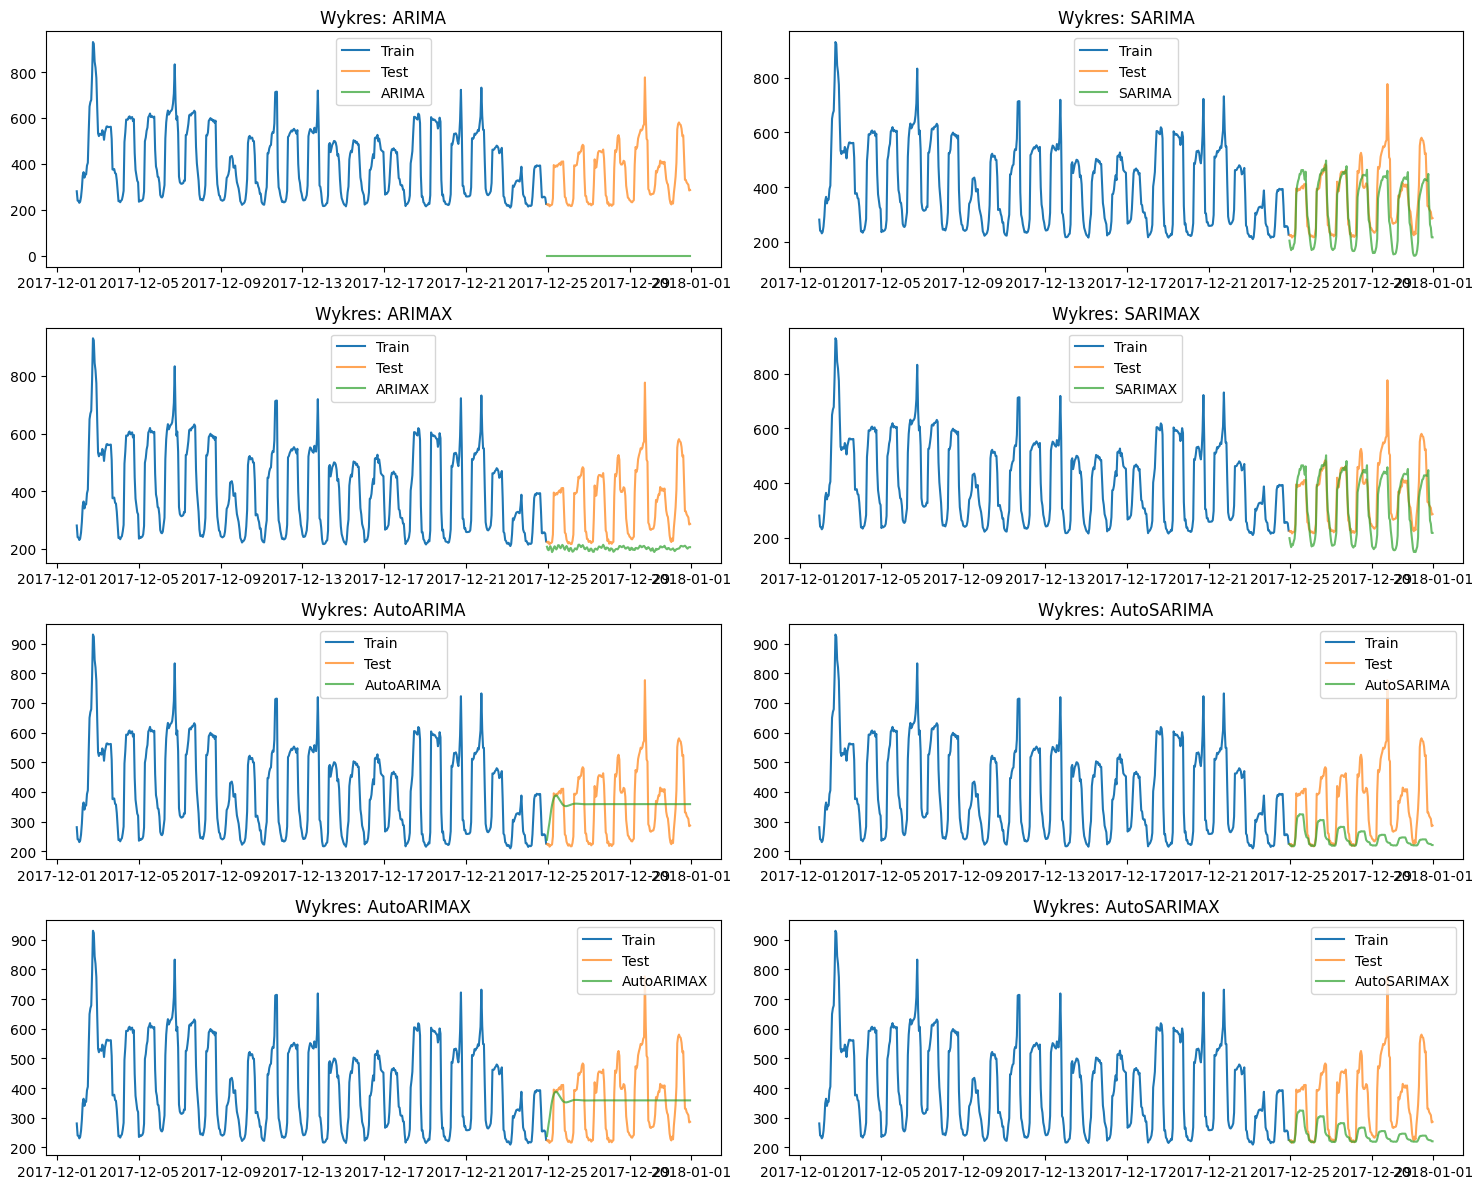


Metryki efektywności:
                   RMSE         MAE      MAPE  Czas treningu  Czas predykcji
Model                                                                       
SARIMA        80.547658   60.816772  0.172221     295.049188       43.724574
SARIMAX       80.746973   61.321922  0.173934            NaN       52.199238
AutoARIMA    111.508925   94.073185  0.287870            NaN       28.528950
AutoARIMAX   111.508925   94.073185  0.287870            NaN       23.693739
AutoSARIMA   154.026279  114.673973  0.264492            NaN      132.164067
AutoSARIMAX  154.026279  114.673973  0.264492            NaN      136.273658
ARIMAX       192.232125  156.653418  0.380050            NaN        1.703966
ARIMA        376.530094  358.836132  1.000000      36.932386        1.461502


In [220]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
axes = axes.flatten()  # Spłaszczenie do 1D listy osi

for i, col in enumerate(results.columns[:8]):
    ax = axes[i]
    ax.plot(train, label='Train')
    ax.plot(test, label='Test', alpha=0.7)
    ax.plot(results[col], label=col, alpha=0.7)
    ax.set_title(f'Wykres: {col}')
    ax.legend()

plt.tight_layout()
plt.show()

# 10. Podsumowanie metryk
metrics_df = pd.DataFrame(metrics).set_index('Model')
print("\nMetryki efektywności:")
print(metrics_df.sort_values('RMSE'))


In [221]:
metrics_df

,RMSE,MAE,MAPE,Czas treningu,Czas predykcji
Model,,,,,
ARIMA,376.530094,358.836132,1.000000,36.932386,1.461502
SARIMA,80.547658,60.816772,0.172221,295.049188,43.724574
ARIMAX,192.232125,156.653418,0.380050,NaN,1.703966
SARIMAX,80.746973,61.321922,0.173934,NaN,52.199238
AutoARIMA,111.508925,94.073185,0.287870,NaN,28.528950
AutoSARIMA,154.026279,114.673973,0.264492,NaN,132.164067
AutoARIMAX,111.508925,94.073185,0.287870,NaN,23.693739
AutoSARIMAX,154.026279,114.673973,0.264492,NaN,136.273658


Porównanie metod - wszystkie

timestamp
2017-03-02 00:00:00    4.4650
2017-03-02 01:00:00    4.2400
2017-03-02 02:00:00    4.3275
2017-03-02 03:00:00    4.4725
2017-03-02 04:00:00    3.9375
                        ...  
2017-03-24 19:00:00    5.2825
2017-03-24 20:00:00    4.3650
2017-03-24 21:00:00    4.0000
2017-03-24 22:00:00    3.9850
2017-03-24 23:00:00    3.9950
Name: energy_consumption, Length: 552, dtype: float64


C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

ARIMA DONE
Reloading Tuner from tuning\energy_forecast\tuner0.json


C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras_tuner\src\engine\oracle.py:102: DeprecationWarning: currentThread() is deprecated, use current_thread() instead
  thread_name = threading.currentThread().getName()
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras_tuner\src\engine\oracle.py:102: DeprecationWarning: getName() is deprecated, get the name attribute instead
  thread_name = threading.currentThread().getName()
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
LSTM DONE
Trenowanie Random Forest...
                     energy_consumption   lag_1    lag_2    lag_3    lag_4  \
timestamp                                                                    
2017-03-02 00:00:00              4.4650     NaN      NaN      NaN      NaN   
2017-03-02 01:00:00              4.2400  4.4650      NaN      NaN      NaN   
2017-03-02 02:00:00              4.3275  4.2400   4.4650      NaN      NaN   
2017-03-02 03:00:00              4.4725  4.3275   4.2400   4.4650      NaN   
2017-03-02 04:00:00              3.9375  4.4725   4.3275   4.2400   4.4650   
...                                 ...     ...      ...      ...      ...   
2017-03-24 19:00:00              5.2825  8.3775  11.0300  12.3600  14.2375   
2017-03-24 20:00:00              4.3650  5.2825   8.3775  11.0300  12.3600   
2017-03-24 21:00:00              4.0000  4.3650   5.2825   8.3775  11.0300   
2017-03-24 22:00:00              3.9850  4.0000   4.3650   5.2825 

C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warn

RF DONE


C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warn

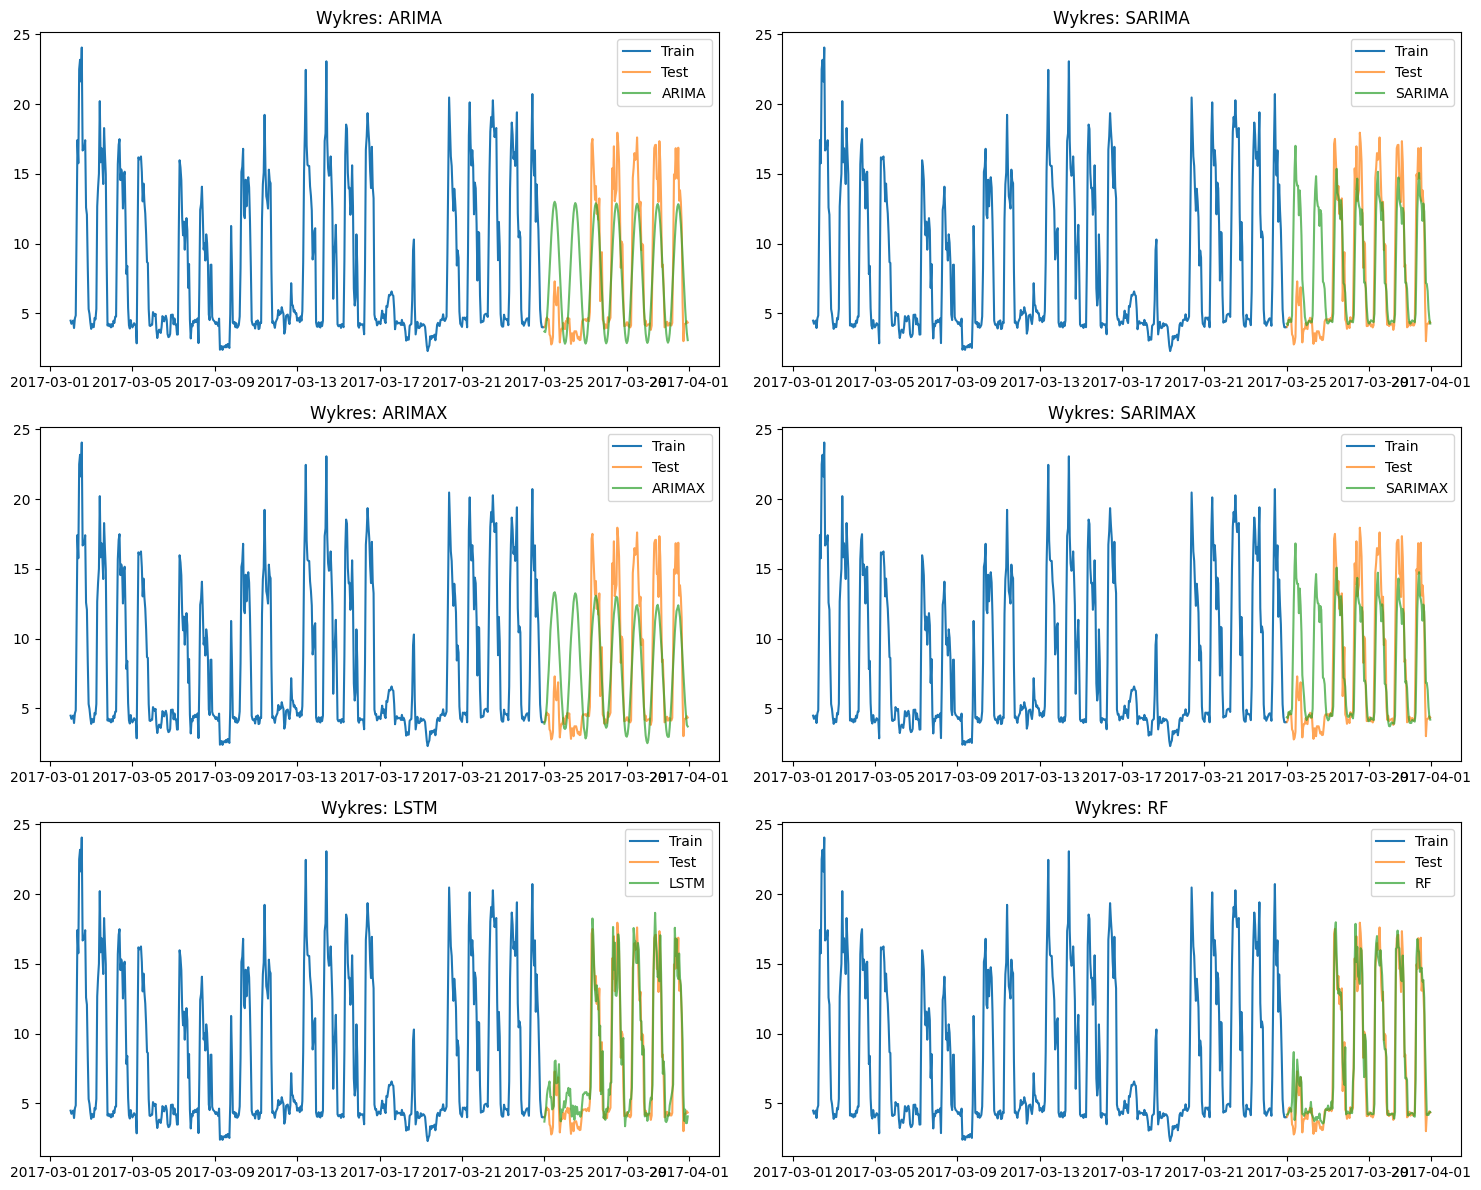


Metryki efektywności:
                   RMSE       MAE      MAPE  Czas treningu  Czas predykcji
Model                                                                     
Random Forest  1.494025  0.938322  0.145149       0.016015        9.906933
LSTM           1.731665  1.325876  0.214544       0.888808        0.317461
ARIMA          3.677479  2.715231  0.494317      16.633700        1.093303
ARIMAX         3.837941  2.834485  0.519306            NaN        1.180786
SARIMA         3.877204  2.496573  0.474358     139.502434       35.158404
SARIMAX        3.886875  2.533480  0.471778            NaN       35.437303


In [277]:
warnings.filterwarnings('ignore')

# Posortuj unikalne building_id
sorted_buildings = sorted(df_final['building_id'].unique())

# Wybierz pierwsze 5 kolejnych
selected_buildings = sorted_buildings[:1]

for i in selected_buildings:
    # data = df_final[df_final['building_id'] == i].copy()  # Use copy() to avoid SettingWithCopyWarning
    # data['timestamp'] = pd.to_datetime(data['timestamp'])  # Ensure timestamp is datetime type
    # data = data.set_index('timestamp').sort_index()
    #
    # # Optional cleaning steps (equivalent to your original data_clean line)
    # data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['airTemperature'])


    df = pd.read_csv('one_building_data.csv', parse_dates=['timestamp'], index_col='timestamp')

    # Ensure the data is sorted by time
    df = df.sort_index()

    features = ['energy_consumption', 'airTemperature', 'sqm']
    target = 'energy_consumption'
    data = df[features].dropna()
    exog = df[['airTemperature']]  # Add other variables if needed


    # Podział na trening (30 dni) i test (7 dni)
    train_lstm = data.iloc[-720:-168]  # 30 dni treningu
    test_lstm = data.iloc[-168:]       # 7 dni testu

    train = df[target][-720:-7*24]
    test = df[target][-7*24:]

    exogTrain = exog[-720:-7*24]
    exogTest = exog[-7*24:]

    # # ARIMA - własna
    arima_model, sarima_model, arimax_model, sarimax_model, arimaTimes = doArimaModels(train, exogTrain)
    print("ARIMA DONE")

    predictions, true_values, lstmTimes = train_and_predict(train_lstm, test_lstm, target)
    print("LSTM DONE")

    rf_model, X_test_rf, y_test_rf, rfTimes = doRandomForest(train, test)
    print("RF DONE")

    results = pd.DataFrame(index=test.index)
    metrics = []

    results['ARIMA'] = arima_model.forecast(steps=len(test))
    metrics.append(evaluate_model(test, results['ARIMA'], 'ARIMA', model_time=arimaTimes['ARIMA'], trening_time=arimaTimes['arimaSearch']))

    # SARIMA
    results['SARIMA'] = sarima_model.forecast(steps=len(test))
    metrics.append(evaluate_model(test, results['SARIMA'], 'SARIMA', model_time=arimaTimes['SARIMA'], trening_time=arimaTimes['arimaSeasonalSearch']))

    if isinstance(exogTest, pd.DataFrame):
        #ARIMAX
        results['ARIMAX'] = arimax_model.forecast(steps=len(test), exog=exogTest)
        metrics.append(evaluate_model(test, results['ARIMAX'], 'ARIMAX', model_time=arimaTimes['ARIMAX']))

        #SARIMAX
        results['SARIMAX'] = sarimax_model.forecast(steps=len(test), exog=exogTest)
        metrics.append(evaluate_model(test, results['SARIMAX'], 'SARIMAX', model_time=arimaTimes['SARIMAX']))

    # LSTM
    results['LSTM'] = predictions
    metrics.append(evaluate_model(test, results['LSTM'], 'LSTM', model_time=lstmTimes['LSTMPredict'], trening_time=lstmTimes['LSTMTrain']))

    # Random Forest
    results['RF'] = rf_model.predict(X_test_rf)
    metrics.append(evaluate_model(test, results['RF'], 'Random Forest', trening_time=rfTimes['RFTrain'], model_time=rfTimes['RFModel']))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()  # Spłaszczenie do 1D listy osi

for i, col in enumerate(results.columns[:6]):
    ax = axes[i]
    ax.plot(train, label='Train')
    ax.plot(test, label='Test', alpha=0.7)
    ax.plot(results[col], label=col, alpha=0.7)
    ax.set_title(f'Wykres: {col}')
    ax.legend()

plt.tight_layout()
plt.show()

# 10. Podsumowanie metryk
metrics_df = pd.DataFrame(metrics).set_index('Model')
print("\nMetryki efektywności:")
print(metrics_df.sort_values('RMSE'))


##### LSTM z zapisem modelu

In [66]:
import numpy as np
import pandas as pd
import time
import os
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import joblib

def doLSTM(train, test, look_back=24, features=None, model_save_dir='saved_models'):

    if features is None:
        features = ['energy_consumption','airTemperature']

    os.makedirs(model_save_dir, exist_ok=True)
    timestamp = time.strftime("%Y%m%d-%H%M%S")

    scaler = MinMaxScaler(feature_range=(0, 1))

    train_data = train[features].values
    test_data = test[features].values

    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    def create_sequences(data, look_back):
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:(i + look_back)])
            y.append(data[i + look_back, 0])  # energy_consumption jest pierwszą cechą
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_scaled, look_back)
    X_test, y_test = create_sequences(test_scaled, look_back)

    # 3. Budowa modelu LSTM
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, len(features))))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # 4. Trenowanie modelu
    start_time = time.time()
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=72,
        validation_split=0.2,
        verbose=0
    )
    training_time = time.time() - start_time

    # 5. Zapis modelu i skalownika
    model_path = os.path.join(model_save_dir, f"lstm_model_{timestamp}.keras")
    scaler_path = os.path.join(model_save_dir, f"scaler_{timestamp}.pkl")

    save_model(model, model_path)
    joblib.dump(scaler, scaler_path)

    print(f"Model zapisany w: {model_path}")
    print(f"Skalownik zapisany w: {scaler_path}")

    return model, X_test, y_test, scaler, training_time, model_path

from tensorflow.keras.models import load_model
import joblib

def load_lstm_model(model_path, scaler_path):
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    return model, scaler

def predict_energy(model, scaler, last_sequence, features, look_back=24):

    raw_seq = last_sequence[features].tail(look_back).values
    scaled_seq = scaler.transform(raw_seq)
    input_seq = scaled_seq.reshape(1, look_back, len(features))
    scaled_pred = model.predict(input_seq)[0][0]
    dummy = np.zeros(shape=(1, len(features)))
    dummy[0, 0] = scaled_pred
    pred = scaler.inverse_transform(dummy)

    return pred[0, 0]

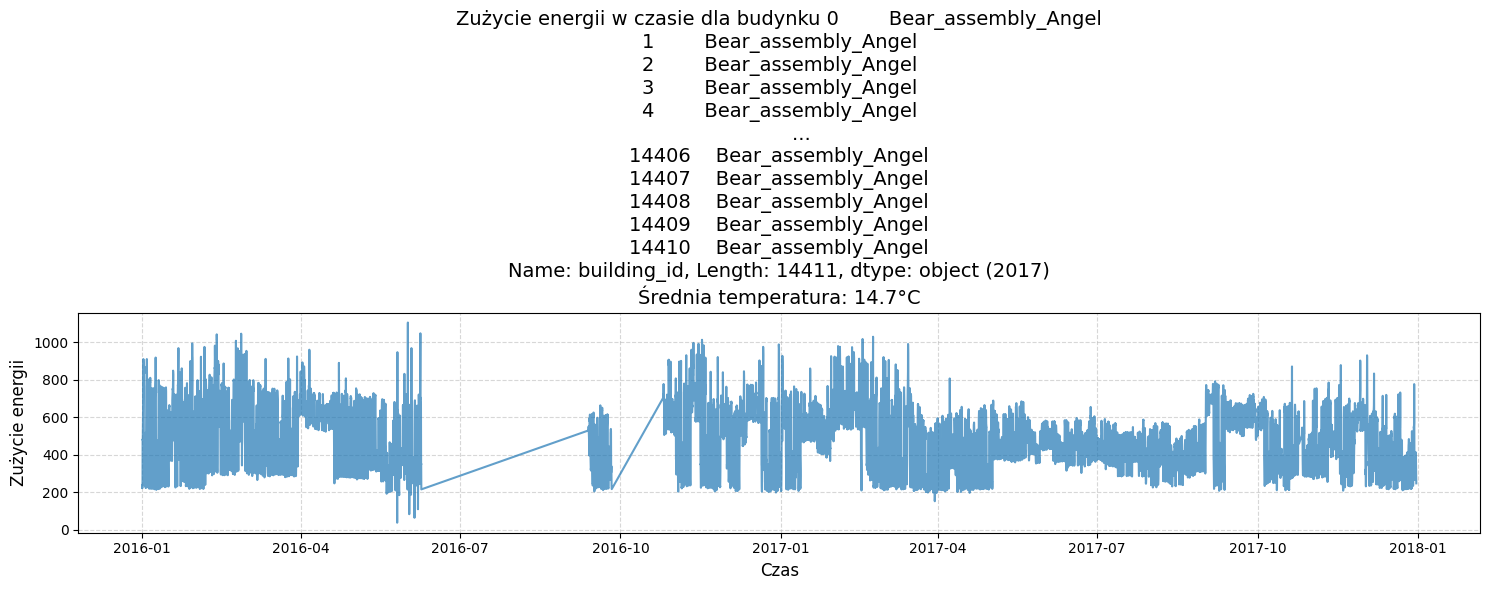

C:\Users\Julia\AppData\Local\Temp\ipykernel_3964\996230553.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.asfreq('H')
C:\Users\Julia\AppData\Local\Temp\ipykernel_3964\996230553.py:10: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data[col] = data[col].interpolate(method='time', limit_direction='both')
C:\Users\Julia\AppData\Local\Temp\ipykernel_3964\996230553.py:10: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data[col] = data[col].interpolate(method='time', limit_direction='both')
C:\Users\Julia\AppData\Local\Temp\ipykernel_3964\996230553.py:10: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy

timestamp
2016-01-01 00:00:00    237.8500
2016-01-01 01:00:00    221.2500
2016-01-01 02:00:00    222.5000
2016-01-01 03:00:00    221.4000
2016-01-01 04:00:00    224.2500
                         ...   
2017-12-30 19:00:00    333.2531
2017-12-30 20:00:00    317.2542
2017-12-30 21:00:00    310.2511
2017-12-30 22:00:00    282.0061
2017-12-30 23:00:00    246.7476
Freq: h, Name: energy_consumption, Length: 17520, dtype: float64
Model zapisany w: energy_models\lstm_model_20250612-205213.keras
Skalownik zapisany w: energy_models\scaler_20250612-205213.pkl


C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


In [67]:
# Posortuj unikalne building_id
sorted_buildings = sorted(df_final['building_id'].unique())

# Wybierz pierwsze 5 kolejnych
selected_buildings = sorted_buildings[:1]

for i in selected_buildings:

    data = df_final[df_final['building_id'] == i].dropna(subset=['energy_consumption'])

    last_24h = data[-24:]  # Keep last 720 rows (e.g., last month)
    data = data[:-24]

    # Visualize before further processing
    visualize(data)

    data = load_and_preprocess(data=data)

    # Extract target
    y = data['energy_consumption']

    # Split sizes
    train_size = int(len(y) * 0.8)

    # Use same indices for both
    train =  data.iloc[:train_size]
    test =  data.iloc[train_size:]

    print(y)

    # Trenowanie i zapis modelu
    model, X_test, y_test, scaler, training_time, model_path = doLSTM(
        train,
        test,
        look_back=24,
        features=['energy_consumption'],
        model_save_dir='energy_models'
    )



In [73]:
    # Ładowanie modelu w innej sesji/procesie
    model, scaler = load_lstm_model(
        model_path='energy_models/lstm_model_20250612-205213.keras',
        scaler_path='energy_models/scaler_20250612-205213.pkl'
    )

    # Pobierz najnowsze dane (ostatnie 24 godziny)
    # last_24h = df.tail(24)

    # Dokonaj predykcji
    prediction = predict_energy(
        model=model,
        scaler=scaler,
        last_sequence=last_24h,
        features=['energy_consumption'],
        look_back=24
    )

    print(f"Przewidywane zużycie energii w następnej godzinie: {prediction:.2f} kWh")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Przewidywane zużycie energii w następnej godzinie: 268.19 kWh


C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\tensorflow\python\framework\ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())
